분석 결과:
       티커               이름    변동성(%)        평균 거래량   평균 스프레드      위험 점수
0  BTC=F  Bitcoin Futures  3.494668  1.148511e+04  0.049156  26.368781
1   ES=F  S&P 500 Futures  0.841673  1.516373e+06  0.011785   6.313717


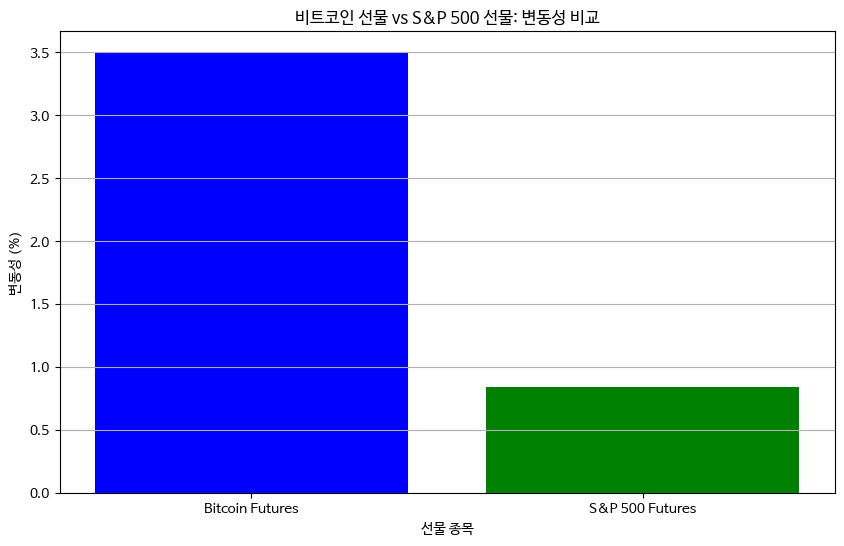

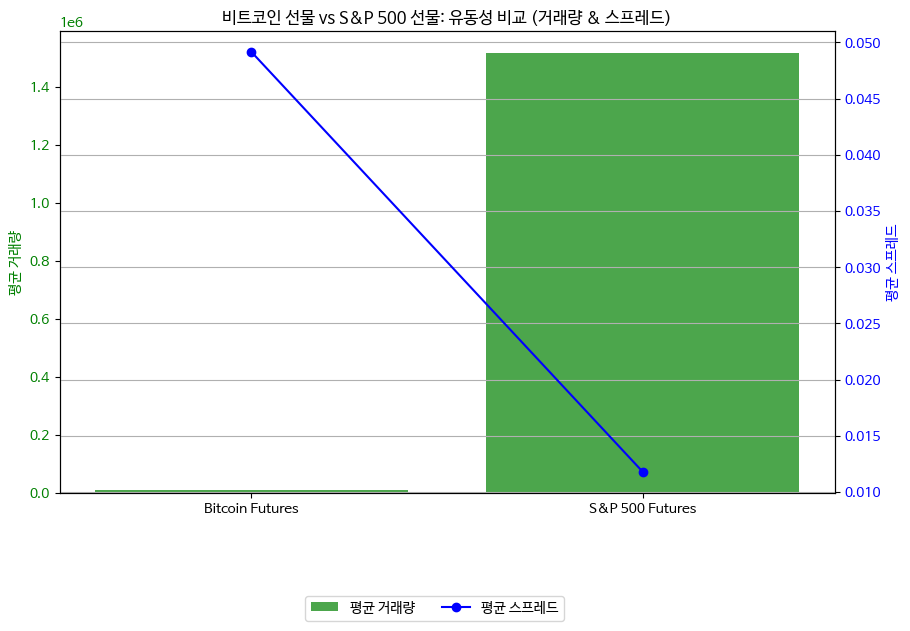

In [16]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# 비트코인 + 주식 선물 혼합
future_tickers = {
    "BTC=F": "Bitcoin Futures",
    "ES=F": "S&P 500 Futures"
}

# 데이터 수집
start_date = "2024-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
future_data = {}

for ticker in future_tickers:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:
        future_data[ticker] = df.reset_index()
    else:
        print(f"{ticker}: 데이터 없음")

# 변동성 계산
def calc_volatility(df):
    if not df.empty and 'Close' in df.columns:
        return df['Close'].pct_change().std().iloc[0] * 100
    return float('nan')

# 유동성 계산
def calc_liquidity(df):
    if not df.empty and all(col in df.columns for col in ['Volume', 'High', 'Low', 'Close']):
        volume = df['Volume'].mean().iloc[0]
        spread = ((df['High'] - df['Low']) / df['Close']).mean().iloc[0]
        return volume, spread
    return float('nan'), float('nan')

# 위험 점수 계산
risk_scores = {}
volatilities = {}
liquidities = {}

for ticker in future_tickers:
    df = future_data.get(ticker)
    if df is not None and not df.empty:
        volatilities[ticker] = calc_volatility(df)
        liquidities[ticker] = calc_liquidity(df)
        vol = volatilities[ticker]
        liq_vol, liq_spread = liquidities[ticker]
        if not pd.isna(vol) and not pd.isna(liq_vol) and not pd.isna(liq_spread):
            score = (vol * 0.5) + ((1/liq_vol + liq_spread) * 1000 * 0.5)
            risk_scores[ticker] = score
        else:
            risk_scores[ticker] = float('nan')
    else:
        volatilities[ticker] = float('nan')
        liquidities[ticker] = (float('nan'), float('nan'))
        risk_scores[ticker] = float('nan')

# 결과 정리
result_df = pd.DataFrame({
    '티커': list(future_tickers.keys()),
    '이름': list(future_tickers.values()),
    '변동성(%)': [volatilities.get(t, float('nan')) for t in future_tickers],
    '평균 거래량': [liquidities.get(t, (float('nan'), float('nan')))[0] for t in future_tickers],
    '평균 스프레드': [liquidities.get(t, (float('nan'), float('nan')))[1] for t in future_tickers],
    '위험 점수': [risk_scores.get(t, float('nan')) for t in future_tickers]
})

print("분석 결과:\n", result_df)

# 그래프 그리기
# 1. 변동성 비교
plt.figure(figsize=(10, 6))
plt.bar(result_df['이름'], result_df['변동성(%)'], color=['blue', 'green'])
plt.title('비트코인 선물 vs S&P 500 선물: 변동성 비교')
plt.xlabel('선물 종목')
plt.ylabel('변동성 (%)')
plt.grid(True, axis='y')
plt.show()

# 2. 유동성 비교 (거래량과 스프레드 함께)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(result_df['이름'], result_df['평균 거래량'], color='green', alpha=0.7, label='평균 거래량')
ax1.set_ylabel('평균 거래량', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(result_df['이름'], result_df['평균 스프레드'], color='blue', marker='o', label='평균 스프레드')
ax2.set_ylabel('평균 스프레드', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('비트코인 선물 vs S&P 500 선물: 유동성 비교 (거래량 & 스프레드)')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.grid(True, axis='y')
plt.show()

# 프레임워크 (경고 시스템)
threshold = 10.0
for ticker, vol in volatilities.items():
    if pd.notna(vol) and vol > threshold:
        print(f"경고: {future_tickers[ticker]} ({ticker}) 변동성 {vol:.2f}%로 위험!")